## Marriage Trends in India

## Import Python Libraries and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('marriage_data_india.csv')
display(data.head())

,ID,Marriage_Type,Age_at_Marriage,Gender,Education_Level,Caste_Match,Religion,Parental_Approval,Urban_Rural,Dowry_Exchanged,Marital_Satisfaction,Divorce_Status,Children_Count,Income_Level,Years_Since_Marriage,Spouse_Working,Inter-Caste,Inter-Religion
0,1,Love,23,Male,Graduate,Different,Hindu,No,Urban,No,Medium,Yes,5,Middle,34,No,No,No
1,2,Love,28,Female,School,Same,Hindu,Yes,Rural,Yes,Low,No,3,Middle,42,No,No,Yes
2,3,Arranged,39,Male,Postgraduate,Same,Muslim,Yes,Rural,No,Medium,No,0,High,25,No,No,No
3,4,Arranged,26,Female,School,Different,Hindu,Yes,Urban,Yes,Low,No,0,High,12,No,Yes,No
4,5,Love,32,Female,Graduate,Same,Hindu,Partial,Rural,Yes,Medium,No,1,Middle,41,No,No,Yes


## Check for Null Values Within the Entire Dataset

In [2]:
display(data.isna().sum())

,0
ID,0
Marriage_Type,0
Age_at_Marriage,0
Gender,0
Education_Level,0
Caste_Match,0
Religion,0
Parental_Approval,0
Urban_Rural,0
Dowry_Exchanged,0


## Do Some Initial Data Cleaning

In [3]:
data.rename(columns={'Inter-Caste':'Inter_Caste', 'Inter-Religion': 'Inter_Religion'}, inplace=True)
data.drop(columns=['ID'], inplace=True)

## Separate the Column Labels by Numeric and Categorical Data

In [4]:
cols_categorical = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Columns:\n{cols_categorical}")

cols_numeric = data.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric Columns:\n{cols_numeric}")

Categorical Columns:
['Marriage_Type', 'Gender', 'Education_Level', 'Caste_Match', 'Religion', 'Parental_Approval', 'Urban_Rural', 'Dowry_Exchanged', 'Marital_Satisfaction', 'Divorce_Status', 'Income_Level', 'Spouse_Working', 'Inter_Caste', 'Inter_Religion']
Numeric Columns:
['Age_at_Marriage', 'Children_Count', 'Years_Since_Marriage']


## Graph the Basic Counts of the Data

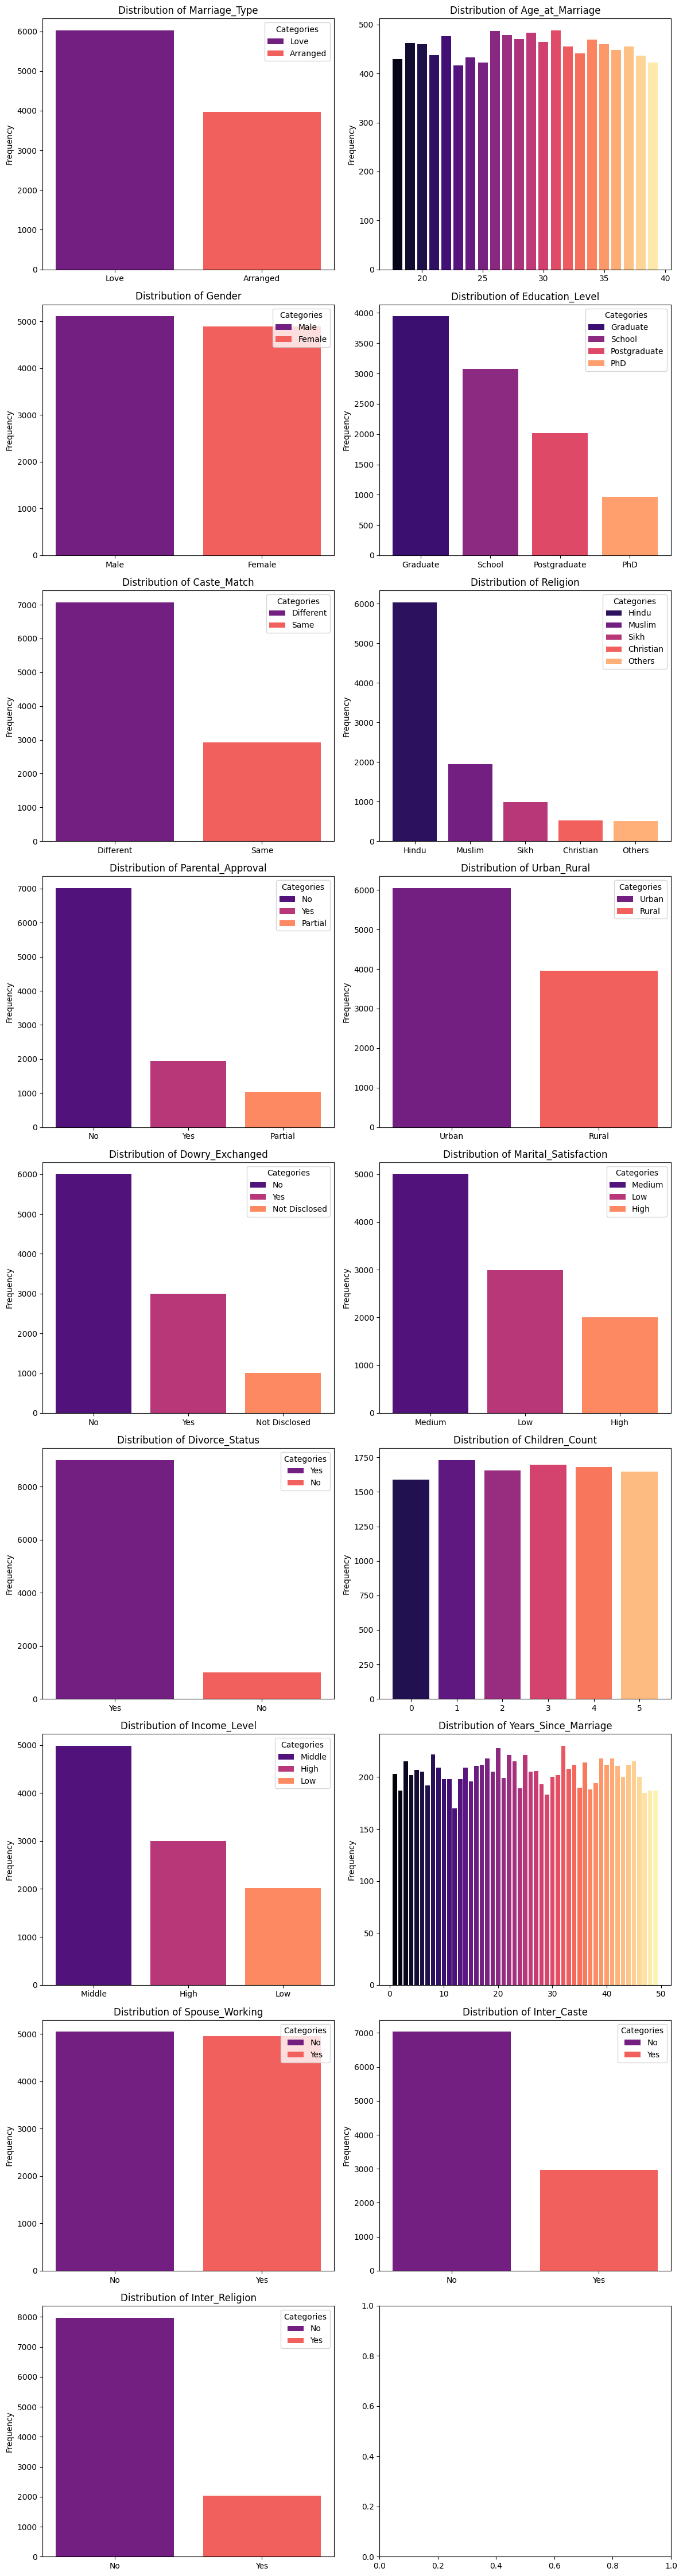

In [5]:
fig, axes = plt.subplots(nrows=(len(data.columns) + 1) // 2, ncols=2, figsize=(12, 5 * ((len(data.columns) + 1) // 2)))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    ax = axes[i]
    x_cats = data[col].unique()
    if col in cols_numeric:
        x_cats = np.sort(x_cats)
        y_counts = data[col].value_counts().sort_index()
    else:
        y_counts = data[col].value_counts()
        colors = sns.color_palette('magma', len(y_counts))
    colors = sns.color_palette('magma', len(y_counts))
    ax.bar(x_cats, y_counts, color=colors, label=x_cats)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col}')
    if not col in cols_numeric:
        ax.legend(x_cats, title='Categories')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).expanded(1.3, 1.25)
    fig.savefig(f'{col}_Distribution.png', bbox_inches=extent)
plt.tight_layout()
plt.savefig('All_Distributions.png')
plt.show()

## Separate the Data Out to $X$ and $y$ Variables

In [6]:
X = data.drop(columns=['Divorce_Status'])
y = data['Divorce_Status']

## One Hot Encode the Categorical Columns

In [7]:
cols_categorical.remove('Divorce_Status')
X = pd.get_dummies(X, columns=cols_categorical, drop_first=True)
display(X.head())

,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
0,23,5,34,True,True,False,False,False,False,True,...,True,False,False,False,True,False,True,False,False,False
1,28,3,42,True,False,False,False,True,True,True,...,False,False,True,True,False,False,True,False,False,True
2,39,0,25,False,True,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
3,26,0,12,False,False,False,False,True,False,True,...,True,False,True,True,False,False,False,False,True,False
4,32,1,41,True,False,False,False,False,True,True,...,False,False,True,False,True,False,True,False,False,True


## Label Encode the $y$ Vector

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

## Use SMOTE to Balance the Data

In [9]:
print(f"Number of '0' class instances in y: {sum(y==0)}")
print(f"Number of '1' class instances in y: {sum(y==1)}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Number of '0' class instances in y after resample: {sum(y_resampled==0)}")
print(f"Number of '1' class instances in y after resample: {sum(y_resampled==1)}")

Number of '0' class instances in y: 8999
Number of '1' class instances in y: 1001
Number of '0' class instances in y after resample: 8999
Number of '1' class instances in y after resample: 8999


## Perform Basic Logistic Regression Before Backwards Elimination

Classification Report for Logistic Regression for Testing Set:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1800
           1       0.84      0.83      0.84      1800

    accuracy                           0.84      3600
   macro avg       0.84      0.84      0.84      3600
weighted avg       0.84      0.84      0.84      3600



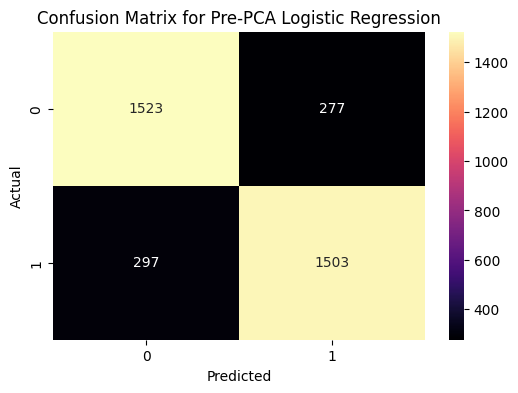

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2, random_state=42, stratify=y_resampled)
scaler = StandardScaler()
X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

clsfrName = "Pre-PCA Logistic Regression"
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Classification Report for Logistic Regression for Testing Set:\n")
print(classification_report(y_test, y_pred))

basic_lr = (clsfrName, classifier)
class_scores_columns = ['ModelName', 'Classifier Score', 'Cross Validation Mean', 'Cross Validation Standard Deviation', 'F1-Score']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title(f"Confusion Matrix for {clsfrName}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f'{clsfrName}_Confusion_Matrix.png')
plt.show()
crossVal = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
f1 = f1_score(y_test, y_pred)
basic_lr_scores = pd.DataFrame([[clsfrName, classifier.score(X_test, y_test), crossVal.mean(), crossVal.std(), f1]], columns=class_scores_columns)
display(basic_lr_scores)

## Perform Backwards Elimination to Find the Most Important Variables in the Dataset

In [11]:
def backwardElimination(x, y, sl):
    numVars = len(x[0])
    indices = list(range(numVars))
    for i in range(0, numVars):
        obj_OLS = sm.OLS(y, x).fit()
        maxVar = max(obj_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, len(indices)):
                if (obj_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    indices.pop(j)
                    break
    display(obj_OLS.summary())
    x = x[:, 1:]
    indices.pop(0)
    indices = [i - 1 for i in indices]
    return x, indices

SL = 0.05
X_backe = np.append(arr=np.ones((len(X_resampled),1)), values=X_resampled, axis=1)
X_backe = X_backe.astype('float64')
X_sig = X_backe
X_Modeled, indices = backwardElimination(X_sig, y_resampled, SL)
print(f'Selected Features Indices: {indices}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     686.1
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:42:24   Log-Likelihood:                -7210.3
No. Observations:               17998   AIC:                         1.447e+04
Df Residuals:                   17973   BIC:                         1.467e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3211      0.015     85.457      0.000       1.291       1.351
x1             0.0011      0.000      2.605      0.009       0.000       0.002
x2            -0.0140      0.002     -8.622      0.000      -0.017      -0.011
x3            -0.0913      0.006    -15.385      0.000      -0.103      -0.080
x4            -0.1074      0.006    -19.173      0.000      -0.118      -0.096
x5            -0.2422      0.012    -20.371      0.000      -0.265      -0.219
x6            -0.2255      0.008    -26.614      0.000      -0.242      -0.209
x7            -0.1842      0.007    -26.631      0.000      -0.198      -0.171
x8            -0.0623      0.006    -10.997      0.000      -0.073      -0.051
x9            -0.2002      0.007    -30.285      0.000      -0.213      -0.187
x10           -0.2801      0.009    -29.722      0.000      -0.299      -0.262
x11           -0.3473      0.017    -20.978      0.000      -0.380      -0.315
x12           -0.3624      0.017    -21.642      0.000      -0.395      -0.330
x13           -0.2765      0.010    -28.645      0.000      -0.295      -0.258
x14           -0.1602      0.007    -23.794      0.000      -0.173      -0.147
x15           -0.0616      0.005    -11.290      0.000      -0.072      -0.051
x16           -0.1826      0.012    -15.851      0.000      -0.205      -0.160
x17           -0.1187      0.007    -17.803      0.000      -0.132      -0.106
x18           -0.2076      0.009    -23.911      0.000      -0.225      -0.191
x19           -0.1369      0.006    -23.063      0.000      -0.149      -0.125
x20           -0.1666      0.007    -22.230      0.000      -0.181      -0.152
x21           -0.1191      0.006    -18.822      0.000      -0.132      -0.107
x22           -0.0899      0.006    -16.026      0.000      -0.101      -0.079
x23           -0.1308      0.007    -19.226      0.000      -0.144      -0.118
x24           -0.1241      0.008    -15.492      0.000      -0.140      -0.108
==============================================================================
Omnibus:                      270.514   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.542
Skew:                           0.306   Prob(JB):                     4.43e-62
Kurtosis:                       3.041   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Selected Features Indices: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## Display the head of the X variable with only the 'important' indices selected

In [12]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns[indices].to_list())
X_resampled.head()

,Age_at_Marriage,Children_Count,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
0,23,5,True,True,False,False,False,False,True,False,...,True,False,False,False,True,False,True,False,False,False
1,28,3,True,False,False,False,True,True,True,False,...,False,False,True,True,False,False,True,False,False,True
2,39,0,False,True,False,True,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
3,26,0,False,False,False,False,True,False,True,False,...,True,False,True,True,False,False,False,False,True,False
4,32,1,True,False,False,False,False,True,True,False,...,False,False,True,False,True,False,True,False,False,True


## Get the numeric columns in the adjusted dataset

In [13]:
cols_numeric = X_resampled.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric Columns:\n{cols_numeric}")

Numeric Columns:
['Age_at_Marriage', 'Children_Count']


## Perform a Test/Train Split Along the Data

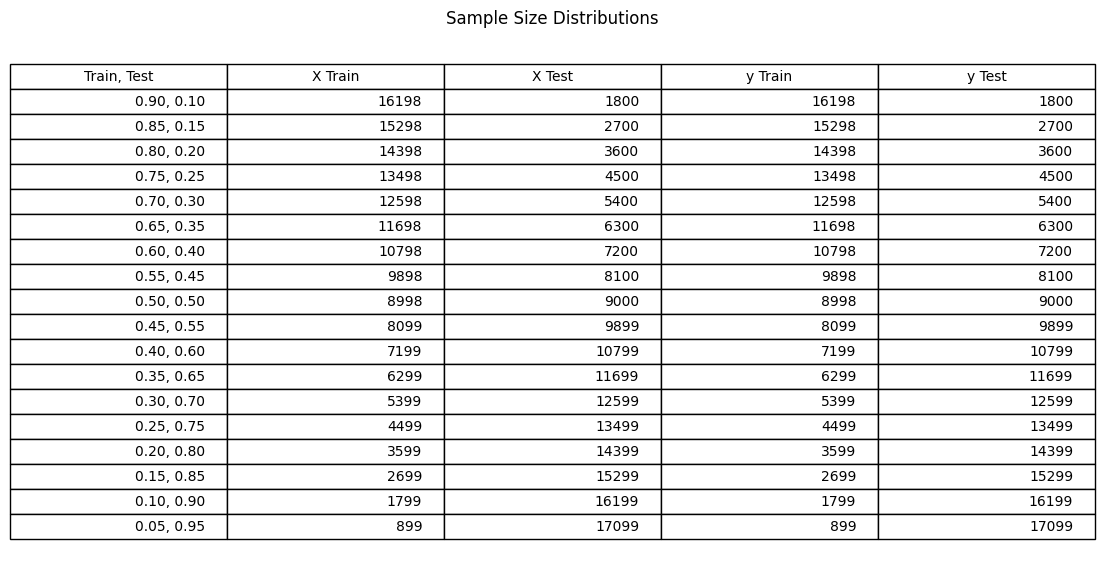

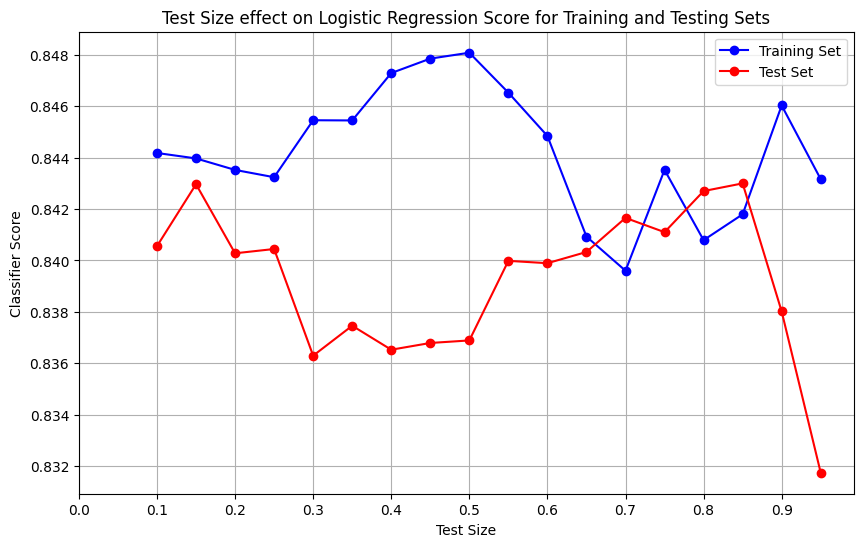

In [14]:
testScores = []
trainScores = []
testSampleSizes = np.arange(0.1, 1.0, 0.05)
tableVals = []
for i in testSampleSizes:
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=i, random_state=42, stratify=y_resampled)

    tableVals.append([f'{1-i:.2f}, {i:.2f}', len(X_train), len(X_test), len(y_train), len(y_test)])

    scaler = StandardScaler()
    X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
    X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    trainScores.append(lr.score(X_train, y_train))
    testScores.append(lr.score(X_test, y_test))

tableCols = ['Train, Test', 'X Train', 'X Test', 'y Train', 'y Test']
fig, ax = plt.subplots(figsize=(14,7))
ax.set_axis_off()
table = ax.table(cellText=tableVals, colLabels=tableCols, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
ax.title.set_text("Sample Size Distributions")
plt.savefig('Sample_Size_Distributions.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(testSampleSizes, trainScores, marker='o', color='blue', linestyle='-', label='Training Set')
plt.plot(testSampleSizes, testScores, marker='o', color='red', linestyle='-', label='Test Set')
plt.title('Test Size effect on Logistic Regression Score for Training and Testing Sets')
plt.xlabel('Test Size')
plt.ylabel('Classifier Score')
plt.xticks(np.arange(0, 1, .1))
plt.savefig('Dataset_Split_Effect_On_LR_Performance.png')
plt.legend()
plt.grid()
plt.show()

## 0.15 Seems to be the Best

In [15]:
#Train/validation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)

## Use a Standard Scaler to Scale the Numeric Data

In [16]:
scaler = StandardScaler()
X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

print("X Training Set Head:")
display(X_train.head())

print("X Testing Set Head:")
display(X_test.head())

X Training Set Head:


,Age_at_Marriage,Children_Count,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
11999,1.358809,-1.399603,False,True,False,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,False
10624,0.874834,-1.399603,True,False,False,False,False,False,True,False,...,True,False,False,False,True,False,False,True,False,False
759,-1.706368,1.591446,False,False,False,False,True,True,True,False,...,True,False,False,False,True,False,True,True,False,False
15295,0.068208,-0.203183,False,True,False,True,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
427,0.713509,-0.203183,False,True,False,False,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False


X Testing Set Head:


,Age_at_Marriage,Children_Count,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
7222,-1.222393,-0.801393,True,True,False,False,False,True,True,False,...,True,False,False,False,True,True,False,False,False,True
11027,0.874834,0.395026,False,False,False,False,True,True,False,False,...,False,False,False,False,True,False,True,False,False,False
78,0.552184,1.591446,False,True,False,False,False,True,True,False,...,True,False,False,False,False,False,True,False,False,False
17457,-1.222393,-1.399603,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
15819,-0.577092,-0.203183,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,True,True,True,False


## Perform PCA on the Prepped Data

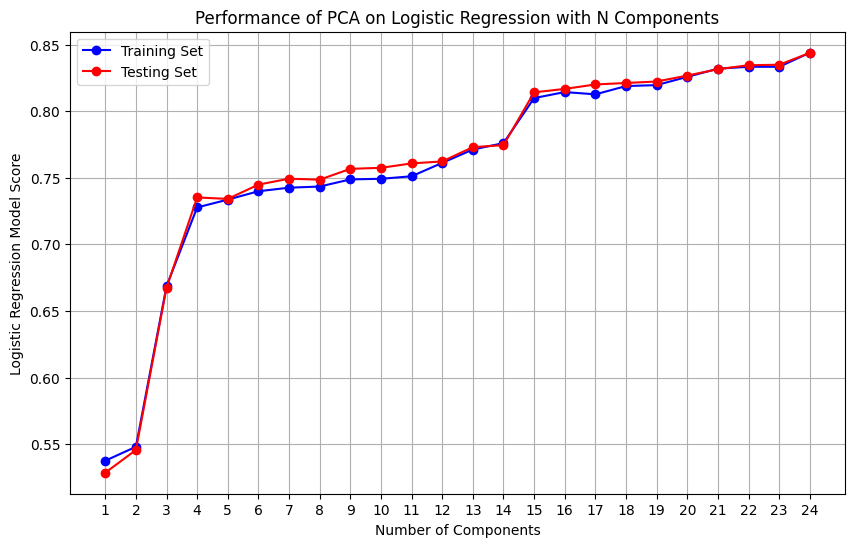

In [17]:
train_scores = []
test_scores = []
upperLimit = len(X_train.columns) + 1
for i in range(1, upperLimit):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    lr = LogisticRegression(random_state=42)
    lr.fit(X_train_pca, y_train)
    train_scores.append(lr.score(X_train_pca, y_train))
    test_scores.append(lr.score(X_test_pca, y_test))


plt.figure(figsize=(10, 6))
plt.plot(range(1, upperLimit), train_scores, marker='o', color='blue', linestyle='-', label='Training Set')
plt.plot(range(1, upperLimit), test_scores, marker='o', color='red', linestyle='-', label='Testing Set')
plt.title('Performance of PCA on Logistic Regression with N Components')
plt.xlabel('Number of Components')
plt.ylabel('Logistic Regression Model Score')
plt.xticks(range(1, upperLimit))
plt.grid()
plt.savefig('PCA_Performance_By_N_Components.png')
plt.legend()
plt.show()

## PCA Takeaways

The graph above indicates that dimensionality reduction does not necessarily improve model accuracy for our data. Therefore, we will continue using the full dataset. For the sake of completeness, we will include PCA metrics alongside our original data.

In [18]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Build a Reusable Method for Training and Testing Models

In [19]:
class_scores = pd.DataFrame(columns=class_scores_columns)
def GraphConfusionMatrix(y_test, y_pred, classifierName):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.title(f"Confusion Matrix for {classifierName}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f'{classifierName}_Confusion_Matrix.png')
    plt.show()

def GraphClassificationReport(y_test, y_pred, classifierName):
    report = classification_report(y_test, y_pred, output_dict=True)
    tableCols = ['', 'Precision', 'Recall', 'F1-Score', 'Support']
    tableVals = [
        ['0', f"{report['0']['precision']:.2f}", f"{report['0']['recall']:.2f}", f"{report['0']['f1-score']:.2f}", f"{report['0']['support']:.0f}"],
        ['1', f"{report['1']['precision']:.2f}", f"{report['1']['recall']:.2f}", f"{report['1']['f1-score']:.2f}", f"{report['1']['support']:.0f}"],
        ['', '', '', '', ''],
        ['Accuracy', '', '', f"{report['accuracy']:.2f}", f"{report['macro avg']['support']:.0f}"],
        ['Macro Avg', f"{report['macro avg']['precision']:.2f}", f"{report['macro avg']['recall']:.2f}", f"{report['macro avg']['f1-score']:.2f}", f"{report['macro avg']['support']:.0f}"],
        ['Weighted Avg', f"{report['weighted avg']['precision']:.2f}", f"{report['weighted avg']['recall']:.2f}", f"{report['weighted avg']['f1-score']:.2f}", f"{report['weighted avg']['support']:.0f}"]
    ]

    fig, ax = plt.subplots(figsize=(8,2.5))
    ax.set_axis_off()
    table = ax.table(cellText=tableVals, colLabels=tableCols, loc='center', colLoc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    for cell in table.get_children():
        cell.set_linewidth(0)
    ax.title.set_text(f'{classifierName} Classification Report')
    plt.savefig(f'{classifierName}_Classification_Report.png')
    plt.show()

def ModelTrainFitAndReport(classifier, classifierName, scoresDataFrame):
    if not isinstance(classifier, VotingClassifier):
        classifier.fit(X_train_pca, y_train)
        y_pred = classifier.predict(X_test_pca)
        GraphClassificationReport(y_test, y_pred, f'{classifierName} PCA')
        crossVal = cross_val_score(estimator=classifier, X=X_train_pca, y=y_train, cv=10)
        f1 = f1_score(y_test, y_pred)
        GraphConfusionMatrix(y_test, y_pred, f'{classifierName} PCA')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    GraphClassificationReport(y_test, y_pred, classifierName)
    crossVal = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
    f1 = f1_score(y_test, y_pred)
    scoresDataFrame.loc[-1] = [classifierName, classifier.score(X_test, y_test), crossVal.mean(), crossVal.std(), f1]
    scoresDataFrame.index = scoresDataFrame.index + 1
    scoresDataFrame = scoresDataFrame.sort_index()
    GraphConfusionMatrix(y_test, y_pred, f'{classifierName}')

    display(scoresDataFrame)

    return (classifierName, classifier)

## Model Selection

### Logistic Regression

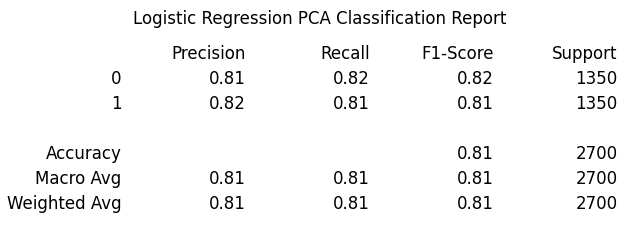

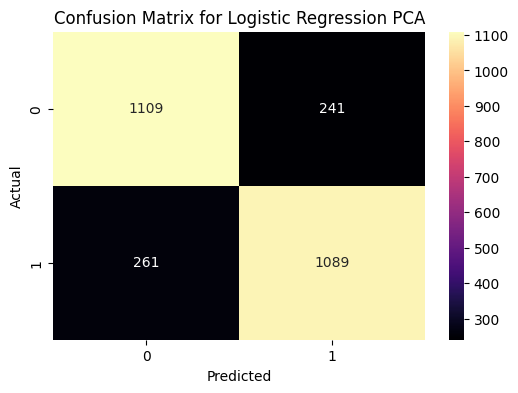

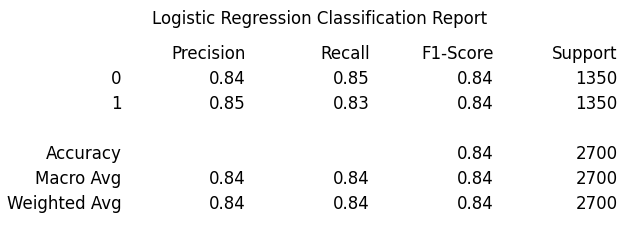

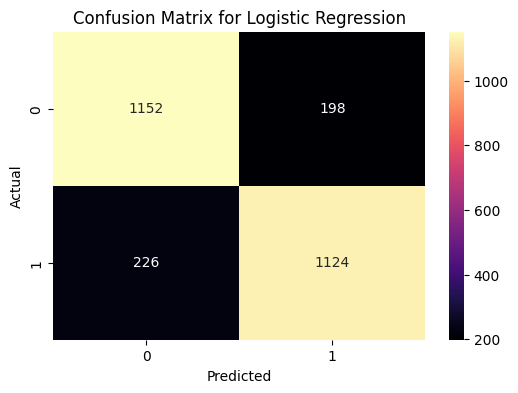

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [20]:
logistic_regression = ModelTrainFitAndReport(LogisticRegression(random_state=42), "Logistic Regression", class_scores)

### Random Forest

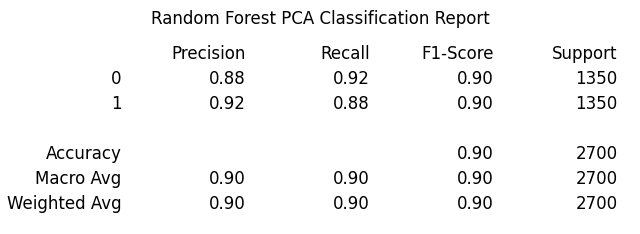

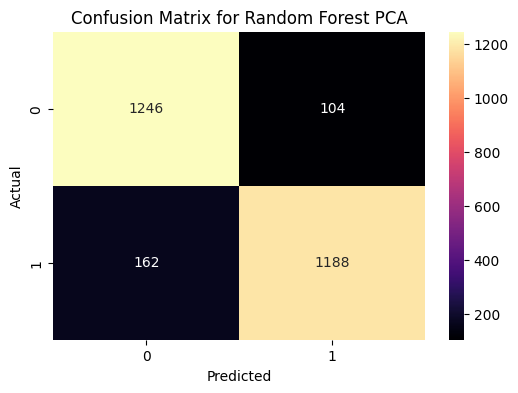

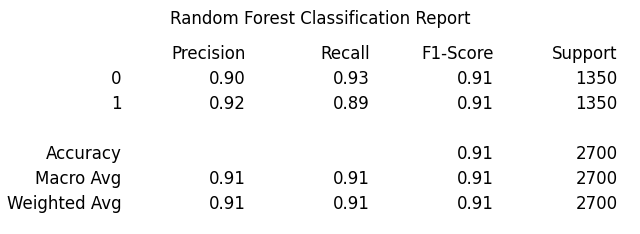

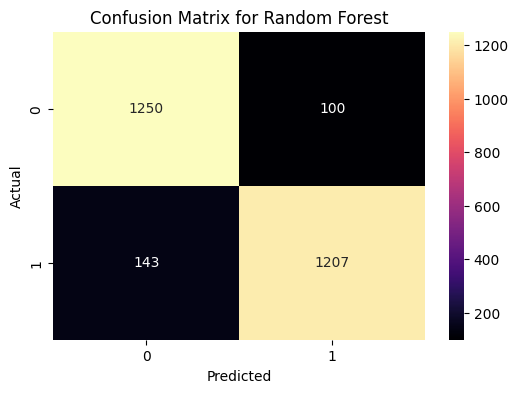

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Random Forest,0.910000,0.907832,0.006996,0.908543
1,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [21]:
random_forest = ModelTrainFitAndReport(RandomForestClassifier(random_state=42), "Random Forest", class_scores)

### Support Vector Classifier

#### RBF Kernel

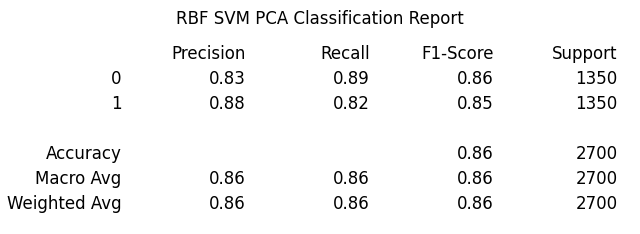

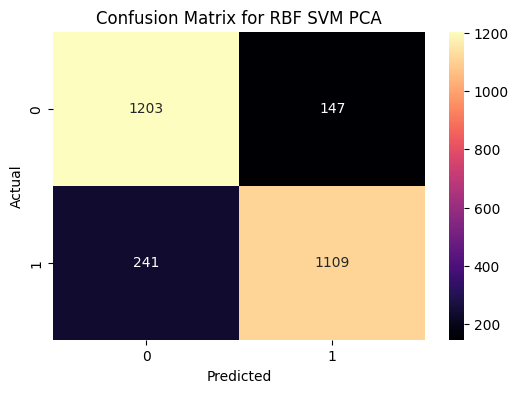

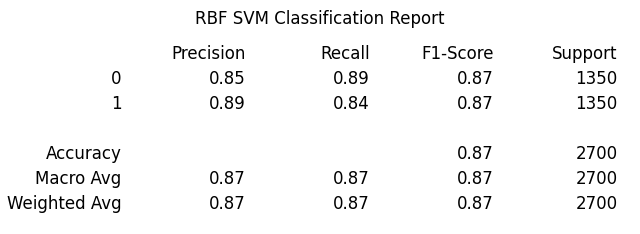

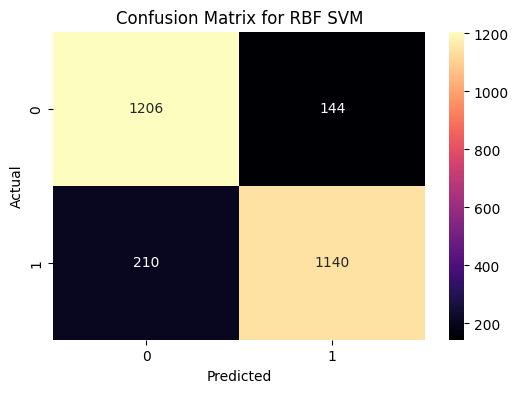

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,RBF SVM,0.868889,0.869789,0.011133,0.865604
1,Random Forest,0.910000,0.907832,0.006996,0.908543
2,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [22]:
rbf_svm = ModelTrainFitAndReport(SVC(kernel='rbf', random_state=42), "RBF SVM", class_scores)

#### Poly Kernel

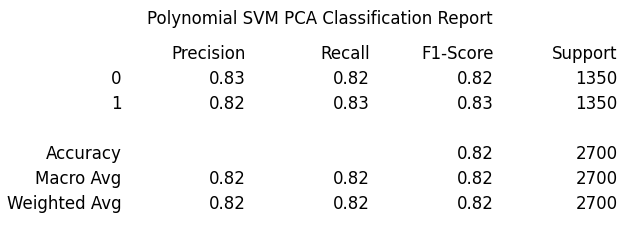

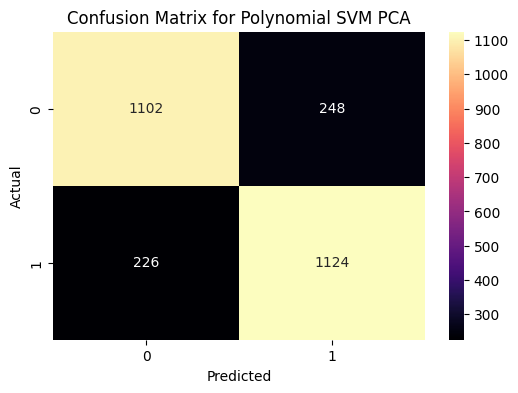

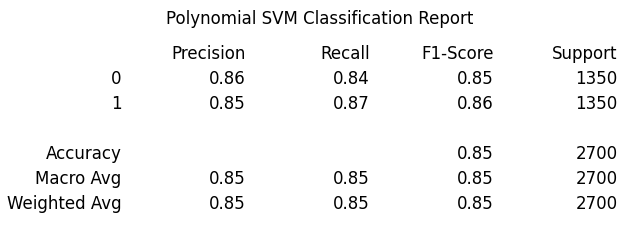

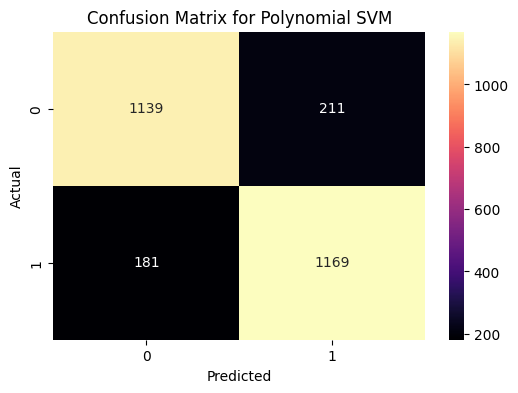

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
1,RBF SVM,0.868889,0.869789,0.011133,0.865604
2,Random Forest,0.910000,0.907832,0.006996,0.908543
3,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [23]:
poly_svm = ModelTrainFitAndReport(SVC(kernel='poly', random_state=42), "Polynomial SVM", class_scores)

### Decision Tree Classifier

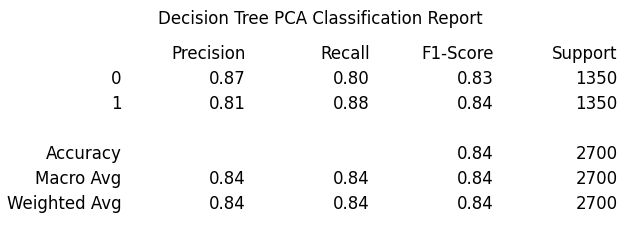

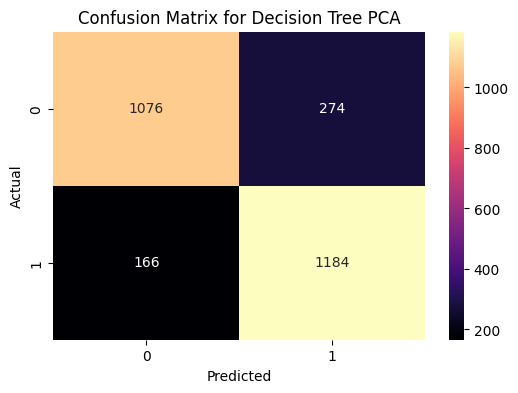

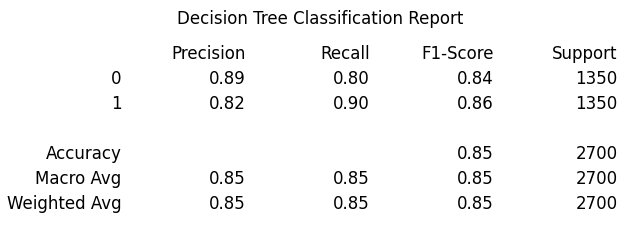

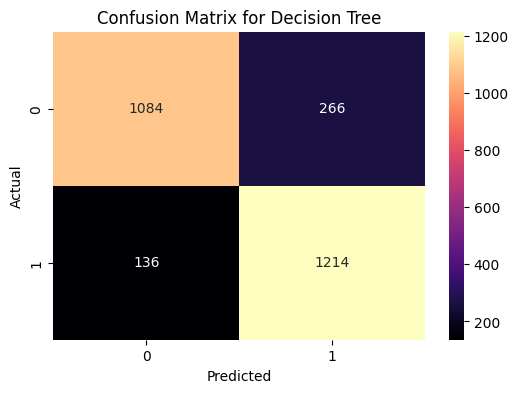

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Decision Tree,0.851111,0.847563,0.010035,0.857951
1,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
2,RBF SVM,0.868889,0.869789,0.011133,0.865604
3,Random Forest,0.910000,0.907832,0.006996,0.908543
4,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [24]:
decision_tree = ModelTrainFitAndReport(DecisionTreeClassifier(criterion='entropy', random_state=42), "Decision Tree", class_scores)

### Naive Bayes Classifier

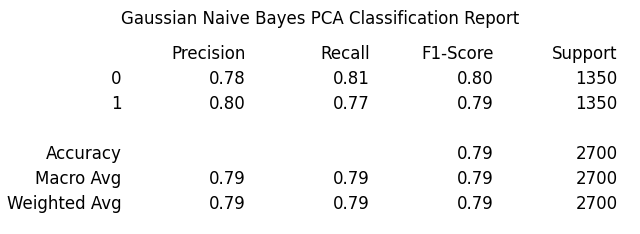

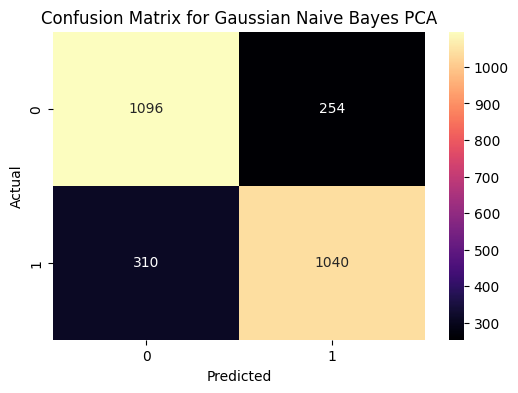

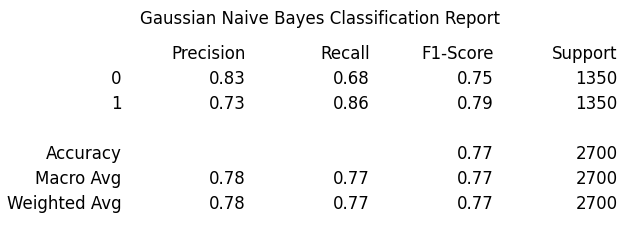

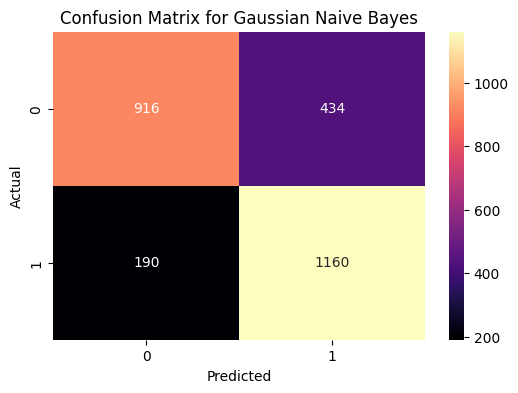

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Gaussian Naive Bayes,0.768889,0.766964,0.009189,0.788043
1,Decision Tree,0.851111,0.847563,0.010035,0.857951
2,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
3,RBF SVM,0.868889,0.869789,0.011133,0.865604
4,Random Forest,0.910000,0.907832,0.006996,0.908543
5,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [25]:
naive_bayes = ModelTrainFitAndReport(GaussianNB(), "Gaussian Naive Bayes", class_scores)

### Adaptive Boost Classifier

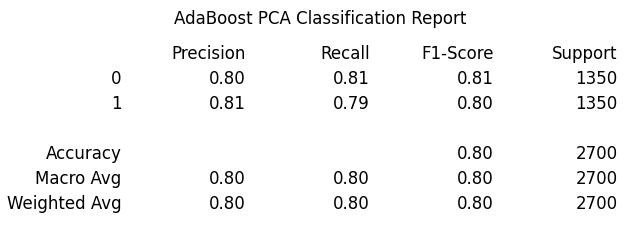

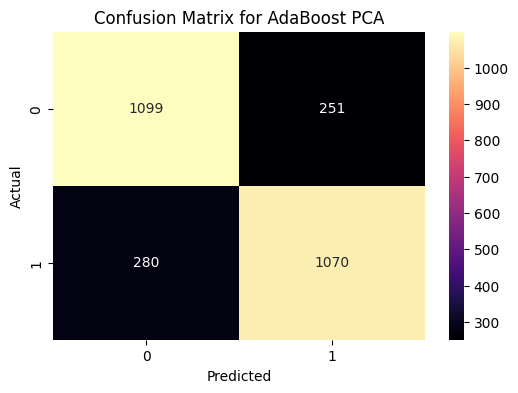

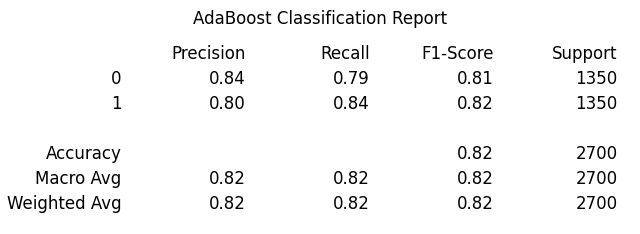

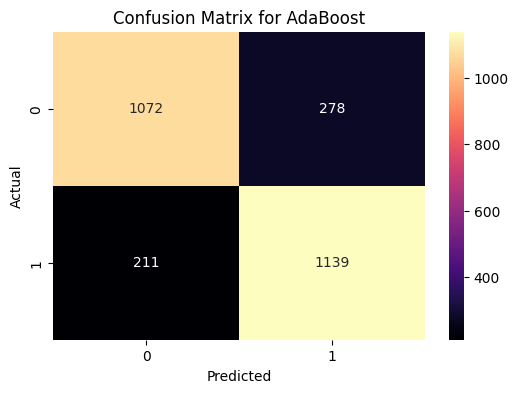

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,AdaBoost,0.818889,0.813965,0.013258,0.823274
1,Gaussian Naive Bayes,0.768889,0.766964,0.009189,0.788043
2,Decision Tree,0.851111,0.847563,0.010035,0.857951
3,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
4,RBF SVM,0.868889,0.869789,0.011133,0.865604
5,Random Forest,0.910000,0.907832,0.006996,0.908543
6,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [26]:
ada_boost = ModelTrainFitAndReport(AdaBoostClassifier(random_state=42), "AdaBoost", class_scores)

### Gradient Boost Classifier

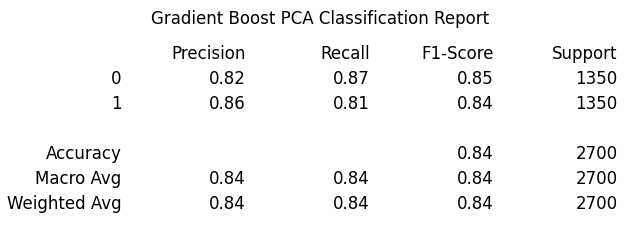

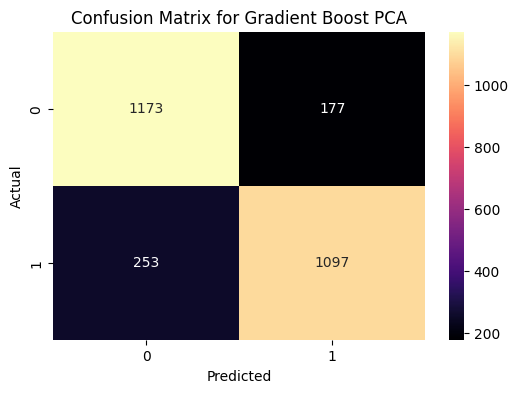

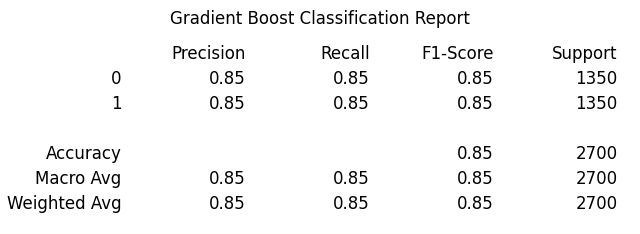

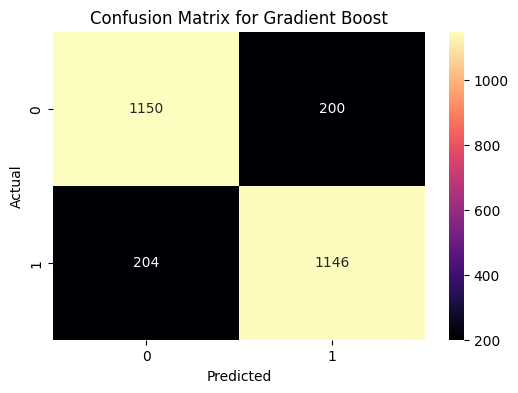

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Gradient Boost,0.850370,0.852008,0.008663,0.850148
1,AdaBoost,0.818889,0.813965,0.013258,0.823274
2,Gaussian Naive Bayes,0.768889,0.766964,0.009189,0.788043
3,Decision Tree,0.851111,0.847563,0.010035,0.857951
4,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
5,RBF SVM,0.868889,0.869789,0.011133,0.865604
6,Random Forest,0.910000,0.907832,0.006996,0.908543
7,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [27]:
gradient_boost = ModelTrainFitAndReport(GradientBoostingClassifier(random_state=42), "Gradient Boost", class_scores)

### XGBoost Classifier

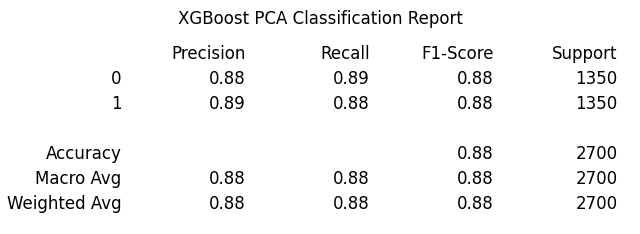

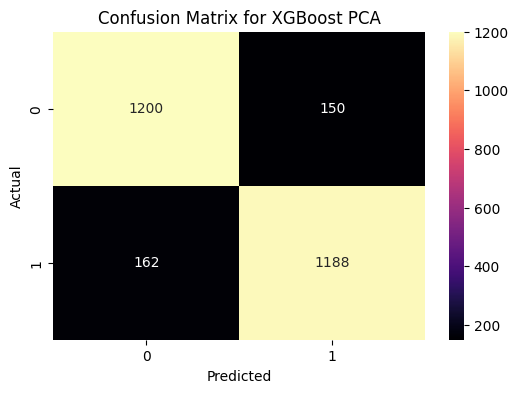

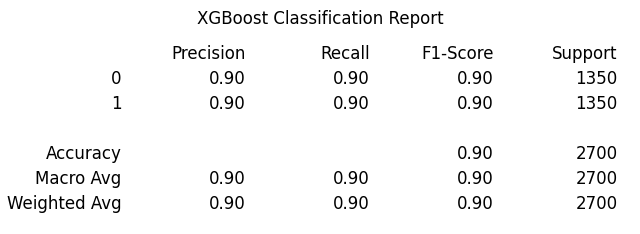

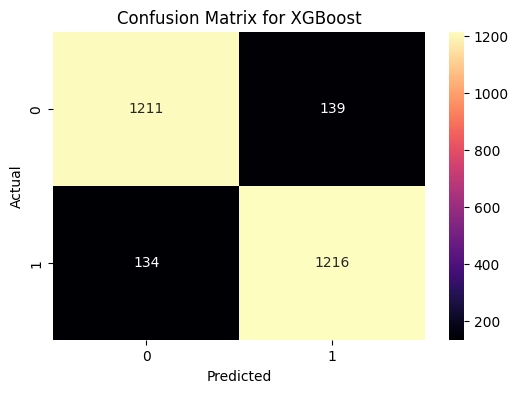

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,XGBoost,0.898889,0.889072,0.010494,0.899076
1,Gradient Boost,0.850370,0.852008,0.008663,0.850148
2,AdaBoost,0.818889,0.813965,0.013258,0.823274
3,Gaussian Naive Bayes,0.768889,0.766964,0.009189,0.788043
4,Decision Tree,0.851111,0.847563,0.010035,0.857951
5,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
6,RBF SVM,0.868889,0.869789,0.011133,0.865604
7,Random Forest,0.910000,0.907832,0.006996,0.908543
8,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [28]:
xgboost = ModelTrainFitAndReport(XGBClassifier(random_state=42), "XGBoost", class_scores)

### $k$-Nearest Neighbors Classifier

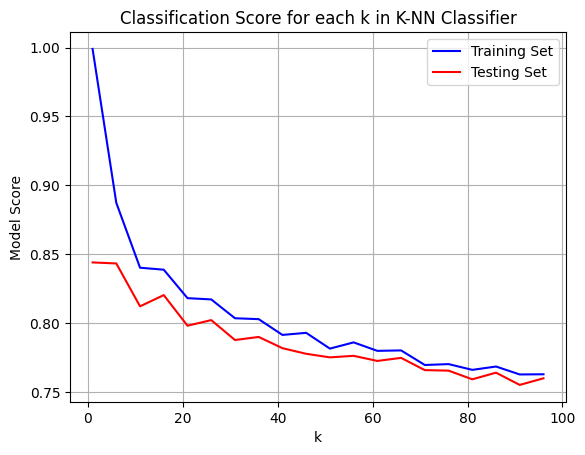

In [29]:
train_scores = []
test_scores = []
ks = np.arange(1, 100, 5)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

plt.plot(ks, train_scores, color='blue', label='Training Set')
plt.plot(ks, test_scores, color='red', label='Testing Set')
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('Classification Score for each k in K-NN Classifier')
plt.grid(True)
plt.legend()
plt.savefig('KNN_Scores.png')
plt.show()

#### Use best $k$ value for $k$-NN

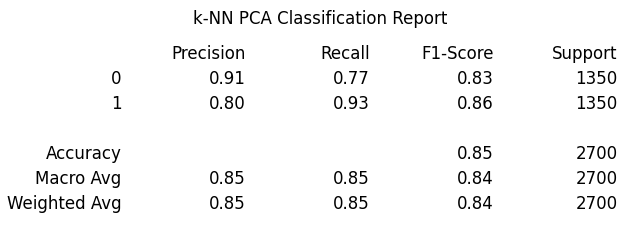

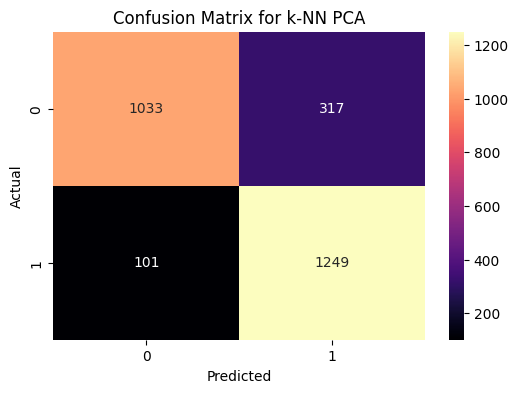

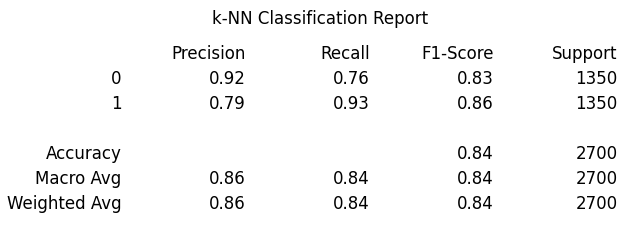

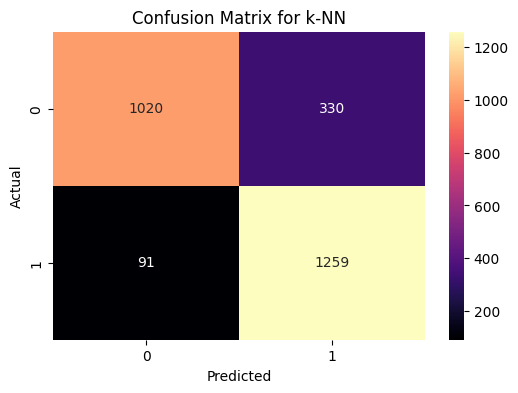

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,k-NN,0.844074,0.844947,0.011805,0.856754
1,XGBoost,0.898889,0.889072,0.010494,0.899076
2,Gradient Boost,0.850370,0.852008,0.008663,0.850148
3,AdaBoost,0.818889,0.813965,0.013258,0.823274
4,Gaussian Naive Bayes,0.768889,0.766964,0.009189,0.788043
5,Decision Tree,0.851111,0.847563,0.010035,0.857951
6,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
7,RBF SVM,0.868889,0.869789,0.011133,0.865604
8,Random Forest,0.910000,0.907832,0.006996,0.908543
9,Logistic Regression,0.842963,0.843445,0.008499,0.841317


In [30]:
knn = ModelTrainFitAndReport(KNeighborsClassifier(n_neighbors=1), "k-NN", class_scores)

### Voting Classifier

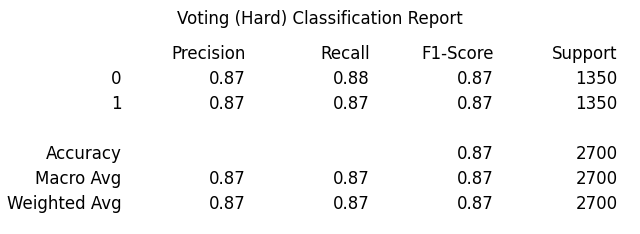

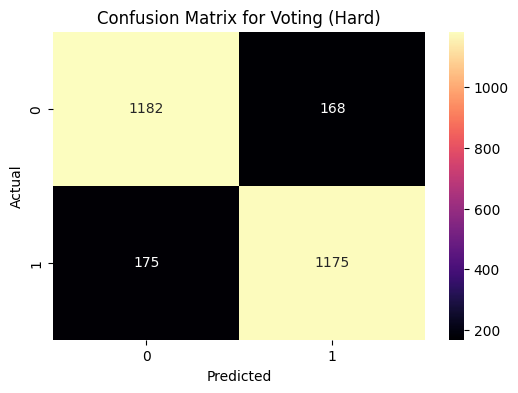

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Voting (Hard),0.872963,0.872338,0.009109,0.872633
1,k-NN,0.844074,0.844947,0.011805,0.856754
2,XGBoost,0.898889,0.889072,0.010494,0.899076
3,Gradient Boost,0.850370,0.852008,0.008663,0.850148
4,AdaBoost,0.818889,0.813965,0.013258,0.823274
5,Gaussian Naive Bayes,0.768889,0.766964,0.009189,0.788043
6,Decision Tree,0.851111,0.847563,0.010035,0.857951
7,Polynomial SVM,0.854815,0.852858,0.011335,0.856410
8,RBF SVM,0.868889,0.869789,0.011133,0.865604
9,Random Forest,0.910000,0.907832,0.006996,0.908543


In [31]:
classifiers = [basic_lr, logistic_regression, random_forest, rbf_svm, poly_svm, decision_tree, naive_bayes, ada_boost, gradient_boost, xgboost, knn]
voting_classifier = ModelTrainFitAndReport(VotingClassifier(estimators=classifiers, voting='hard'), "Voting (Hard)", class_scores)

## Display Model Performance Metrics of Each Model

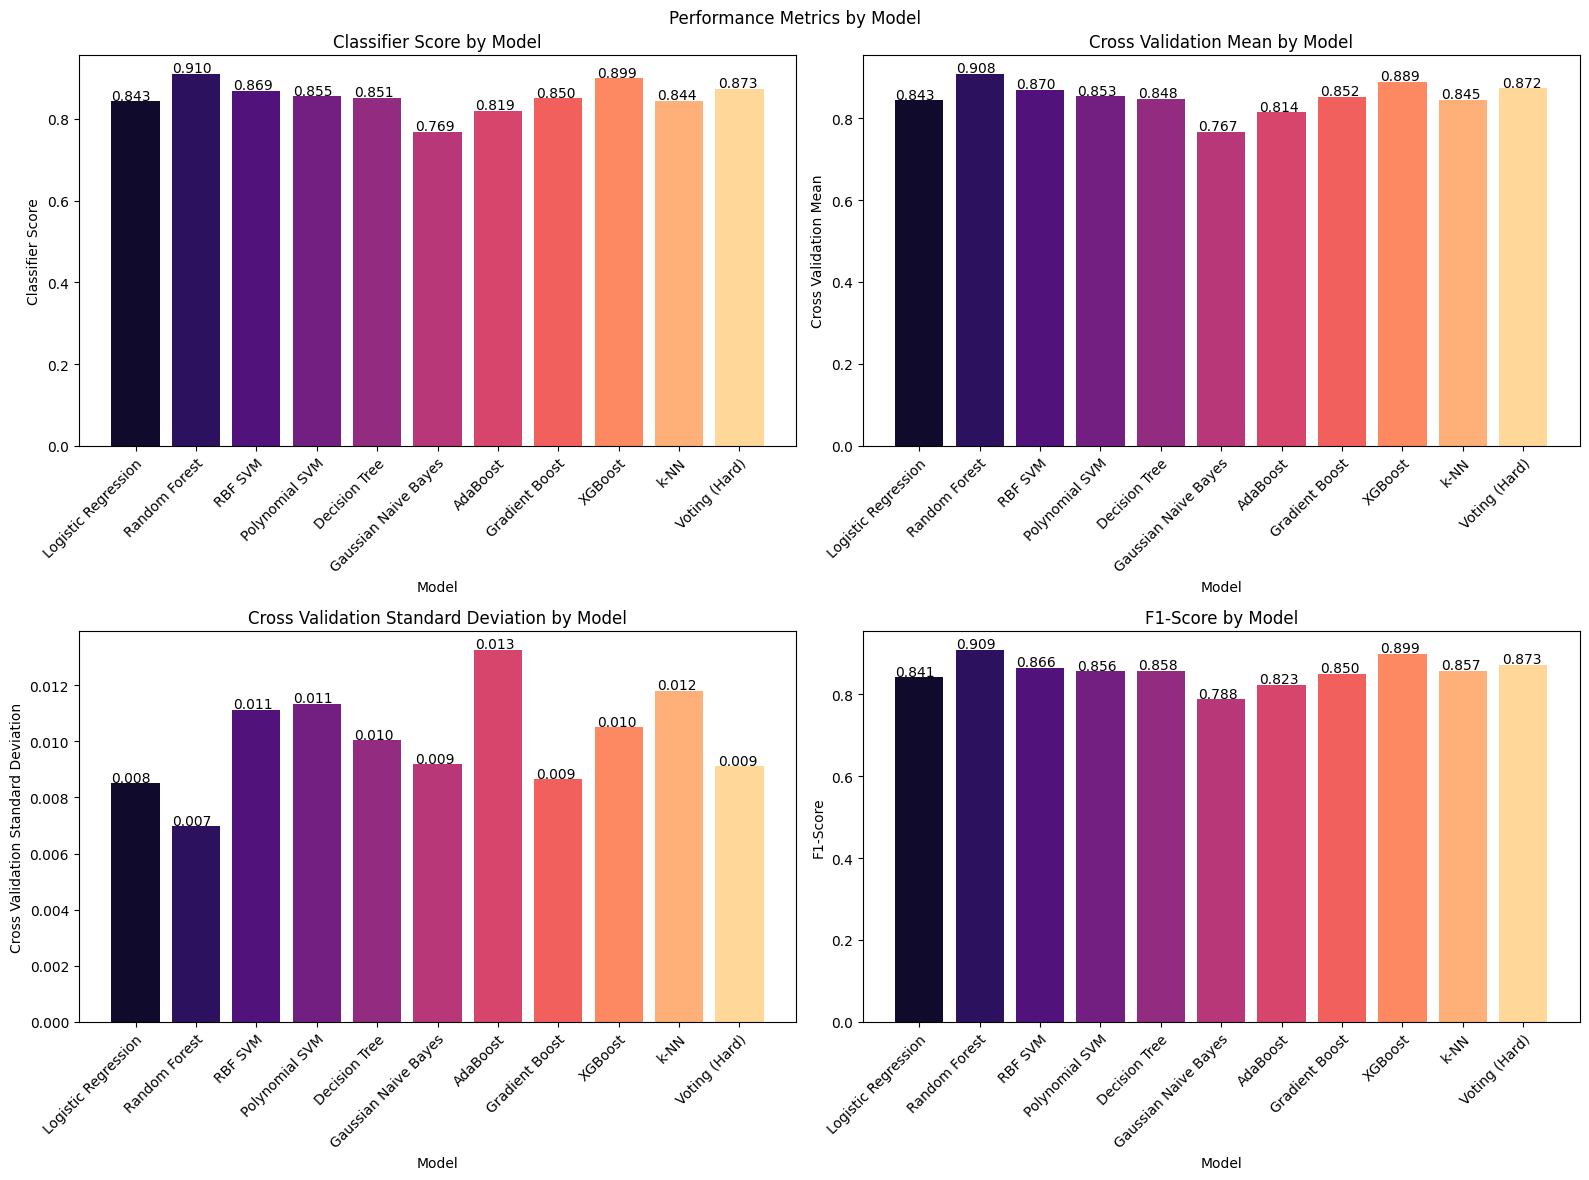

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Performance Metrics by Model')
axes = axes.flatten()
for i in range(1, 5):
    ax = axes[i - 1]
    colors = sns.color_palette('magma', len(class_scores['ModelName']))
    ax.bar(class_scores['ModelName'], class_scores.iloc[:, i], color=colors)
    ax.set_ylabel(class_scores.columns[i])
    ax.set_xlabel('Model')
    ax.set_title(f'{class_scores.columns[i]} by Model')
    ax.set_xticks(np.arange(len(class_scores['ModelName'])))
    ax.set_xticklabels(class_scores['ModelName'], rotation=45, ha='right', rotation_mode='anchor')
    #ax.tick_params(axis='x', labelrotation=45)
    for p in ax.patches:
      ax.annotate(f'{p.get_height():.3f}', (p.get_x() * 1.005, p.get_height() * 1.005))
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).expanded(1.25, 1.25)
    fig.savefig(f'{col.replace(" ", "_")}_by_Model.png', bbox_inches=extent)
plt.tight_layout()
plt.savefig('All_Model_Metrics.png')
plt.show()

## Test With New Data

In [34]:
def MakePredictionOnNewData(new_data):
    new_data[cols_numeric] = scaler.transform(new_data[cols_numeric])
    y_pred = voting_classifier[1].predict(new_data)

    result = ""
    if y_pred[0] == 1:
        result = "Will Divorce"
    else:
        result = "Will Not Divorce"

    print(f"Divorce Status Prediction: {result}")

new_data = pd.DataFrame([[32, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]], columns=X_resampled.columns)
MakePredictionOnNewData(new_data)

new_data_will_divorce = pd.DataFrame([[34, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]], columns=X_resampled.columns)
MakePredictionOnNewData(new_data_will_divorce)

Divorce Status Prediction: Will Not Divorce
Divorce Status Prediction: Will Divorce
